In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import ensemble
import sklearn.metrics
import time
from datetime import datetime

%matplotlib inline                                
#no need to do plt.show()

In [4]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)
train.head()

 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')


,id,date,speed
0,0,2017-01-01 00:00:00,43.002930
1,1,2017-01-01 01:00:00,46.118696
2,2,2017-01-01 02:00:00,44.294158
3,3,2017-01-01 03:00:00,41.067468
4,4,2017-01-01 04:00:00,46.448653


In [5]:
###处理特征


for df in (train,test): 
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekdayth"] = df['date'].dt.weekday
    df["weekofyear"] = df['date'].dt.isocalendar().week.astype("int")
    df["season"] = df['date'].dt.quarter.fillna(0).astype("int")
    df["dayofyear"] = df['date'].dt.dayofyear
    
    
for df in (train,test):
    df['y/n-weekday'] = np.nan  
    df.loc[(df.weekdayth>=5),'y/n-weekday']=1  #周六周天为1    #int转
    df.loc[(df.weekdayth<=4),'y/n-weekday']=0  #工作日为0
    
# #时 转 白天黑夜早晚高峰      ：date speed year month day hr weekday weekofyear season dayofyear hr-categori
# for df in (train,test):
#     df['hr-categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
#     df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr-categori'] = "3"   #工作日的早高峰7-9点
#     df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr <= 19)&(df.hr >= 17), 'hr-categori'] = "3"  #工作日的晚高峰17-19点
    
#     df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr >= 0)&(df.hr < 7), 'hr-categori'] = "0"
#     df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr > 9)|(df.hr < 17), 'hr-categori'] = "1"
#     df.loc[(df.weekday <= 4)&(df.weekday >= 0)&(df.hr >19)&(df.hr <= 24), 'hr-categori'] = "2"

#     df.loc[(df.weekday >= 5)&(df.hr < 19)&(df.hr > 7), 'hr-categori'] = "4"                        #周末的白天
#     df.loc[(df.weekday >= 5)&(df.hr <= 7)|(df.hr >= 19), 'hr-categori'] = "5"                    #周末的晚上


public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

    
    
df_train = train.drop(columns= ['only-ymd','date','id'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()


In [6]:
df_train.corr()['speed']    

speed          1.000000
year           0.015102
month         -0.028827
day           -0.019485
hr            -0.390044
weekdayth      0.115887
weekofyear    -0.026907
season        -0.022967
dayofyear     -0.030255
y/n-weekday    0.144478
y/n-holiday    0.055386
Name: speed, dtype: float64

In [7]:
df_train.head()

,speed,year,month,day,hr,weekdayth,weekofyear,season,dayofyear,y/n-weekday,y/n-holiday
0,43.002930,2017,1,1,0,6,52,1,1,1.0,0
1,46.118696,2017,1,1,1,6,52,1,1,1.0,0
2,44.294158,2017,1,1,2,6,52,1,1,1.0,0
3,41.067468,2017,1,1,3,6,52,1,1,1.0,0
4,46.448653,2017,1,1,4,6,52,1,1,1.0,0


In [8]:
df_test.head()

,year,month,day,hr,weekdayth,weekofyear,season,dayofyear,y/n-weekday,y/n-holiday
id,,,,,,,,,,
0,2018,1,1,2,0,1,1,1,0.0,1
1,2018,1,1,5,0,1,1,1,0.0,1
2,2018,1,1,7,0,1,1,1,0.0,1
3,2018,1,1,8,0,1,1,1,0.0,1
4,2018,1,1,10,0,1,1,1,0.0,1


In [20]:
####不需要编码了
from sklearn.model_selection import train_test_split

Train, Valid = train_test_split(df_train, test_size = 0.2)     

In [21]:
X_train = Train.drop(['speed'], axis=1)     

Y_train = Train["speed"]                    

X_valid = Valid.drop(['speed'], axis=1)       

Y_valid = Valid["speed"]                      


Y_valid = Y_valid.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

dtrain = xgb.DMatrix(X_train, label=Y_train)    
dvalid = xgb.DMatrix(X_valid, label=Y_valid)      

dtest = xgb.DMatrix(df_test)                

In [35]:
xgb_pars = {
    'nthread':            4,  
    'objective':          'reg:squarederror',
    'learning_rate':      0.05,
    'min_child_weight':   0.8,   
    'max_depth':          50,  
    'subsample':          0.5,
    'colsample_bytree':   1,
    'colsample_bylevel':  0.68,
    'verbosity':             0,
    'reg_alpha':          0.4,
    'gamma':              0,
    #'reg_lambda':         0.4,
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(xgb_pars, dtrain, 3000, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)



[0]	train-rmse:33.34239	valid-rmse:33.23756
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:31.73789	valid-rmse:31.65232
[2]	train-rmse:30.20618	valid-rmse:30.13930
[3]	train-rmse:28.75151	valid-rmse:28.70015
[4]	train-rmse:27.37636	valid-rmse:27.34403
[5]	train-rmse:26.14039	valid-rmse:26.11632
[6]	train-rmse:24.90370	valid-rmse:24.89684
[7]	train-rmse:23.72195	valid-rmse:23.73498
[8]	train-rmse:22.60759	valid-rmse:22.63332
[9]	train-rmse:21.54311	valid-rmse:21.58695
[10]	train-rmse:20.54490	valid-rmse:20.60475
[11]	train-rmse:19.58675	valid-rmse:19.66488
[12]	train-rmse:18.67831	valid-rmse:18.77296
[13]	train-rmse:17.81945	valid-rmse:17.92790
[14]	train-rmse:17.00402	valid-rmse:17.12767
[15]	train-rmse:16.22620	valid-rmse:16.36292
[16]	train-rmse:15.48745	valid-rmse:15.64104
[17]	train-rmse:14.79094	valid-rmse:14.96257
[18]	train-rmse:14.12221	valid-rmse:14.30318
[19]	train-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

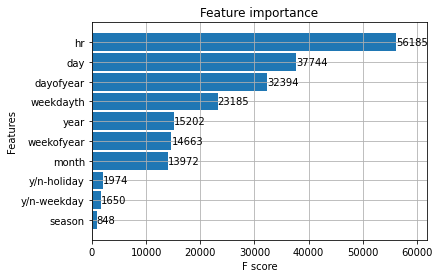

In [12]:
fscores = model.get_fscore()

xgb.plot_importance(model, max_num_features=20, height=0.9)

In [28]:
pred = model.predict(dtest)
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission14.csv", index=False)